In [1]:
#from keras.applications import DenseNet201
import tensorflow as tf
# from keras.applications import InceptionV3
# from keras.applications import VGG16



# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
DenseNet201 = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in DenseNet201.layers:
    layer.trainable = False
    
# Let's print our layers 
# for (i,layer) in enumerate(MobileNet.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [2]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model

BatchNormalization = tf.keras.layers.BatchNormalization()

# Set our class number to 4
num_classes = 2

FC_Head = lw(DenseNet201, num_classes)

model = Model(inputs = DenseNet201.input, outputs = FC_Head)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv4_block22_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block22_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block22_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block22_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block22_concat (Concatena (None, 14, 14, 960)  0           conv4_block21_concat[0][0]       
                                                                 conv4_block22_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block23_0_bn (BatchNormal (None, 14, 14, 960)  3840        conv4_block22_concat[0][0]       
__________________________________________________________________________________________________
conv4_block23_0_relu (Activatio (None, 14, 14, 960)  0           conv4_block23_0_bn[0][0]         
__________

conv5_block10_concat (Concatena (None, 7, 7, 1216)   0           conv5_block9_concat[0][0]        
                                                                 conv5_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_bn (BatchNormal (None, 7, 7, 1216)   4864        conv5_block10_concat[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_relu (Activatio (None, 7, 7, 1216)   0           conv5_block11_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block11_1_conv (Conv2D)   (None, 7, 7, 128)    155648      conv5_block11_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block11_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block11_1_conv[0][0]       
__________

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/val/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 64
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 3433 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [5]:
#from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("faceMask_recognition(with-gpu).h5",
                             monitor="val_loss",
                             save_best_only = True,
                             verbose=1,
                             mode = 'auto',
                             save_freq = 'epoch')

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 7,
                          verbose = 1,
                          mode = 'auto')

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]
# callbacks = [checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
# model.compile(loss = 'categorical_crossentropy',
#               optimizer = SGD(lr=0.01),
#               metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 3433
nb_validation_samples = 400

# We only train 5 EPOCHS 
epochs = 20
batch_size = 64

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
#     steps_per_epoch = 11,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
#     validation_steps=2
)

Epoch 1/20
 5/53 [=>............................] - ETA: 3:40 - loss: 1.1505 - accuracy: 0.6562

D:\Application\Anaconda\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


53/53 [==============================] - 310s 5s/step - loss: 0.2093 - accuracy: 0.9261 - val_loss: 0.0146 - val_accuracy: 0.9922

Epoch 00001: val_loss improved from inf to 0.01463, saving model to faceMask_recognition(with-gpu).h5
Epoch 2/20
53/53 [==============================] - 204s 4s/step - loss: 0.0481 - accuracy: 0.9825 - val_loss: 0.0117 - val_accuracy: 0.9948

Epoch 00002: val_loss improved from 0.01463 to 0.01172, saving model to faceMask_recognition(with-gpu).h5
Epoch 3/20
53/53 [==============================] - 193s 4s/step - loss: 0.0422 - accuracy: 0.9834 - val_loss: 0.0091 - val_accuracy: 0.9948

Epoch 00003: val_loss improved from 0.01172 to 0.00911, saving model to faceMask_recognition(with-gpu).h5
Epoch 4/20
53/53 [==============================] - 135s 3s/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0127 - val_accuracy: 0.9974

Epoch 00004: val_loss did not improve from 0.00911
Epoch 5/20
53/53 [==============================] - 116s 2s/step - loss: 0.030

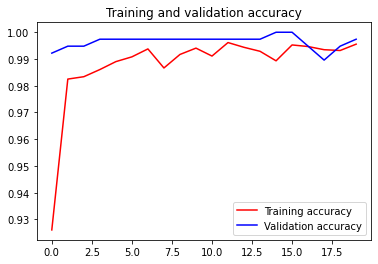

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

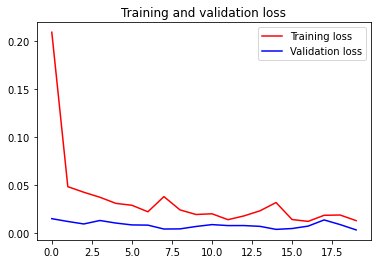

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np


probas = model.predict_generator(generator=validation_generator)
y_true = validation_generator.classes
y_pred = np.argmax(probas, axis=1)

print(y_true.shape)
print(y_pred.shape)


print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

D:\Application\Anaconda\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(400,)
(400,)
[[ 94 106]
 [105  95]]
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       200
           1       0.47      0.47      0.47       200

    accuracy                           0.47       400
   macro avg       0.47      0.47      0.47       400
weighted avg       0.47      0.47      0.47       400



## Load The Model

In [1]:
from keras.models import load_model
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

classifier = load_model('result2/faceMask_recognition(with-gpu).h5')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def face_extractor(img):
    # Function detects faces and returns the cropped face
    # If no face detected, it returns the input image
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img)
    
    if faces is ():
        return None
    
    # Crop all faces found
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-1-e534d42b4e13>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


In [2]:
facial_recog_dict = {"[0]": "With Mask",
                     "[1]": "Without Mask"}

facial_recog_dict_n = {"n0": "With Mask",
                       "n1": "Without Mask"}

def draw_test(name, pred, im):
    facial = facial_recog_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, facial, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + facial_recog_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name) 

video_capture = cv2.VideoCapture(0)
while True:
    _, frame = video_capture.read()
    frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    face=face_extractor(frame)
    if type(face) is np.ndarray:
        
        face = cv2.resize(face, (224, 224), interpolation = cv2.INTER_LINEAR)
        face = face / 255.
        face = face.reshape(1,224,224,3)
        
        res = np.argmax(classifier.predict(face, 1, verbose = 0), axis=1)
    
        # Show image with predicted class
        draw_test("Prediction", res, frame)

        
#         im = Image.fromarray(face, 'RGB')
#         img_array = np.array(im)            
#         img_array = np.expand_dims(img_array, axis=0)
#         pred = classifier.predict(img_array)
# #         print(pred[0])
                     
        
#         cv2.putText(frame,name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    else:
        cv2.putText(frame,"There is no face in the frame", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

# for i in range(0,20):
#     input_im = getRandomImage("./fixdata/")
#     input_original = input_im.copy()
#     input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
#     input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
#     input_im = input_im / 255.
#     input_im = input_im.reshape(1,224,224,3)
    
#     # Get Prediction
#     res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
#     # Show image with predicted class
#     draw_test("Prediction", res, input_original)
#     cv2.waitKey(0)

# cv2.destroyAllWindows()

KeyboardInterrupt: 

# Convert a Saved Model to Tflite
Only if you want to deploy ML model to apps

In [2]:
import tensorflow as tf

model = tf.keras.models.load_model('result2/faceMask_recognition(with-gpu).h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
open("faceMask_recognition(with-gpu).tflite", "wb").write(tflite_model)

print("Model Converted...")

INFO:tensorflow:Assets written to: C:\Users\RIFQIC~1\AppData\Local\Temp\tmps8l10cvd\assets
Model Converted...
